Notebook for taking raw parquet file reads and subsetting to regions of interest \
and collapsing samples by cell type. This notebook outputs parquet files by celltype.

In [1]:
import pandas as pd
import glob
import numpy as np
import itertools
import functools
import os
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col, expr
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



In [2]:
#--- Local paths
ROOT_DIR = '/analysis/gh-msun/projects'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
PROJECT_DIR = ROOT_DIR + f'/{PROJECT_SLUG}'
DATA_DIR = ROOT_DIR + f'/{PROJECT_SLUG}' + '/stage'
SAMPLE_PATH = DATA_DIR + '/metadata/samples_wgbs.20230329.tsv'

#--- parquet
PARQUET_PATH_LIST_HG38 = [
    '/analysis/data/hg38_20160816.pat.db_version.parquet'
]

#--- regions
REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'

REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#-- output
RESULTS_PATH='/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/mixture_source/'

# Subset parquets to regions of interest

### Load regions we want to subset
Load regions of interest to subset. e.g. The ATLAS dataframe contains BLUEPRINT immune regions only. The regions we want to subset to should be represented as a set of region id called `subset_region_set`

In [3]:
# #-------------- CHANGE HERE FOR DIFFERENT REGION SUBSET ----------------------
# # BLUEPRINT immune regions
# ATLAS_PATH = PROJECT_DIR + f'/output/deconv_inhouse_v2.atlas.tsv.gz'
# atlas = pd.read_csv(ATLAS_PATH, sep='\t')
# subset_region_set = set(atlas.region_id)
# #-----------------------------------------------------------------------------

# # filter regions down to regions of interest
# region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)
# region_df_subset = region_df[region_df['region_id'].isin(subset_region_set)]
# region_df_subset.shape


In [4]:
%%time
cpg_map = pd.read_csv(CPG_MAP_PATH, usecols=['chr', 'start', 'end', 'cpg_index', 'cpg_index_hg38'], sep='\t')
ridxs = ~cpg_map['cpg_index_hg38'].isna()
hg19_hg38_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index'], cpg_map[ridxs]['cpg_index_hg38'].astype(int)))
hg38_hg19_map = dict(itertools.zip_longest(cpg_map[ridxs]['cpg_index_hg38'].astype(int), cpg_map[ridxs]['cpg_index']))

CPU times: user 40.3 s, sys: 5.99 s, total: 46.3 s
Wall time: 46.3 s


In [5]:
region_df = pd.read_csv(REGION_PATH, sep='\t', usecols=range(0, 6), names=REGION_BED_COLS)
region_df.shape

(1658, 6)

In [6]:
region_df.head()

,region_chr,region_start,region_end,region_cpg_index_min,region_cpg_index_max,region_id
0,chr1,1114771,1114971,20117,20130,Immune_Broad_B-chr1:1114772-1114971
1,chr1,1157450,1157720,21684,21704,Immune_Broad_NK-chr1:1157451-1157720
2,chr1,1157879,1158277,21710,21727,Immune_Broad_NK-chr1:1157880-1158277
3,chr1,1652503,1652793,41590,41599,Loyfer2022_Preprint_Colon-Ep:Gastric-Ep:Small-...
4,chr1,1849567,1849674,46692,46698,Pancreas_Acinar-chr1:1849568-1849674


In [7]:
%%time ## <-- potentially faster by saving
region_df['region_cpg_index_max'] -= 1
region_df.sort_values('region_cpg_index_min', inplace=True)
region_df['region_cpg_index_min_hg38'] = region_df['region_cpg_index_min'].map(hg19_hg38_map)
region_df['region_cpg_index_max_hg38'] = region_df['region_cpg_index_max'].map(hg19_hg38_map)

region_df.shape[0], region_df['region_id'].nunique()

UsageError: Can't use statement directly after '%%time'!


### Load parquet file as a pyspark dataframe

In [ ]:
# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

In [ ]:
PAT_COLS = [
    'sample_id', 'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string'
]

In [ ]:
pat_parquet_files = [spark.read.parquet(ifile).select(*PAT_COLS) for ifile in PARQUET_PATH_LIST_HG38]
pat_hg38_ddf = functools.reduce(DataFrame.unionByName, pat_parquet_files)
pat_hg38_ddf.printSchema()

In [ ]:
# # check for duplicate molecules
# pat_hg38_ddf.count()
# pat_hg38_ddf.filter(col("number_molecules") == 1).count()
# pat_hg38_ddf.filter(col("number_molecules") > 1).count()

### Create a dataframe of reads that fall in the subsetted regions

In [ ]:
%%time
BATCH_SIZE = 20
region_df['batch'] = (np.arange(region_df.shape[0])/BATCH_SIZE).astype(int)
rv_scores = list()
for batch, batch_region_df in region_df.groupby('batch'):
    rv_ov = list()
    print('---> Processing batch %i...' % batch)
    for _, row in batch_region_df.iterrows():
        ov_ddf = pat_hg38_ddf.filter(col('cpg_index_min')<=row['region_cpg_index_max_hg38'])\
            .filter(col('cpg_index_max') >= row['region_cpg_index_min_hg38'])\
            .withColumn('region_id', lit(row['region_id']))\
            .withColumn('region_cpg_index_min', lit(row['region_cpg_index_min_hg38']))\
            .withColumn('region_cpg_index_max', lit(row['region_cpg_index_max_hg38']))
        rv_ov.append(ov_ddf)
        
    scores_df = functools.reduce(DataFrame.union, rv_ov)
    scores_df_pandas = scores_df.toPandas()
    scores_df_spark = spark.createDataFrame(scores_df_pandas) 
    
    rv_scores.append(scores_df_spark)

In [ ]:
%%time
combined_df = functools.reduce(DataFrame.union, rv_scores)

In [ ]:
rv_scores[0].show(5)

In [ ]:
rv_scores[2].filter(col("number_molecules") == 1).count()

# Create parquet file for each cell type

In [135]:
dataSource = 'blueprint_loyfer2022'

cellType = [   
    'Blueprint-B',
    'Blueprint-CD4',
    'Blueprint-CD8',
    'Blueprint-NK',
    'Blueprint-Dend',
    'Blueprint-Macro',
    'Blueprint-Mono',
    'Blueprint-Eosi',
    'Blueprint-Neutro',
    'Blueprint-Eryth',
    'Blueprint-Mega',
  #  'Eryth-prog'
]

# get samples that fall under these cell types of interest
sample_df = pd.read_csv(SAMPLE_PATH, sep='\t')
ridxs = (sample_df['source']==dataSource)
ridxs &= sample_df['sample_group'].isin(cellType)
ref_sample_df = sample_df[ridxs].copy()
ref_sample_df.head()

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
211,ERS661049,BM030613,band form neutrophil,Blueprint-Neutro,65 - 70,blueprint_loyfer2022,NaN,NaN
212,ERS661048,BM030613,neutrophilic metamyelocyte,Blueprint-Neutro,65 - 70,blueprint_loyfer2022,NaN,NaN
213,ERS661047,BM030613,neutrophilic myelocyte,Blueprint-Neutro,65 - 70,blueprint_loyfer2022,NaN,NaN
214,ERS661050,BM030613,segmented neutrophil of bone marrow,Blueprint-Neutro,65 - 70,blueprint_loyfer2022,NaN,NaN
215,ERS661063,BM060814,band form neutrophil,Blueprint-Neutro,80 - 85,blueprint_loyfer2022,NaN,NaN


In [137]:
ref_sample_df[ref_sample_df['age'] == '0 - 5']

,sample_id,patient_id,cell_type,sample_group,age,source,stage_group,tumor_purity
223,ERS666927,F2012-2912,precursor B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
224,ERS337605,F2012-2912,precursor lymphocyte of B lineage,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
227,ERS227748,C00184,mature neutrophil,Blueprint-Neutro,0 - 5,blueprint_loyfer2022,NaN,NaN
228,ERS214672,C003K9,CD38-negative naive B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
229,ERS206483,C004GD,mature neutrophil,Blueprint-Neutro,0 - 5,blueprint_loyfer2022,NaN,NaN
230,ERS206569,C005PS,"CD14-positive, CD16-negative classical monocyte",Blueprint-Mono,0 - 5,blueprint_loyfer2022,NaN,NaN
231,ERS222241,C0066P,"CD8-positive, alpha-beta T cell",Blueprint-CD8,0 - 5,blueprint_loyfer2022,NaN,NaN
232,ERS222243,C0067N,cytotoxic CD56-dim natural killer cell,Blueprint-NK,0 - 5,blueprint_loyfer2022,NaN,NaN
233,ERS214675,C0068L,CD38-negative naive B cell,Blueprint-B,0 - 5,blueprint_loyfer2022,NaN,NaN
234,ERS214682,S000RD,"CD14-positive, CD16-negative classical monocyte",Blueprint-Mono,0 - 5,blueprint_loyfer2022,NaN,NaN


In [108]:
# how many samples do each cell type have?
ref_sample_df.groupby('sample_group').sample_id.count()

sample_group
Blueprint-B         17
Blueprint-CD4       14
Blueprint-CD8       10
Blueprint-Dend       2
Blueprint-Eosi       2
Blueprint-Eryth      2
Blueprint-Macro     18
Blueprint-Mega       2
Blueprint-Mono       8
Blueprint-NK         4
Blueprint-Neutro    21
Name: sample_id, dtype: int64

In [26]:
%%time

# ---- loop for collapsing samples by cell type
region_read_count = []

for celltype in cellType:
    
    print(f'--> Processing: ### {celltype} ###')

    # get samples in the specified cell type
    samples_by_celltype = list(ref_sample_df[ref_sample_df['sample_group'] == celltype]['sample_id'])
    sample_size = len(samples_by_celltype)
    print(f'-------> sample size: {sample_size}')

    # filter reads that are from samples in samples_by_celltype
    print(f'-------> filtering reads')
    df_celltype = combined_df.filter((col('sample_id')).isin(samples_by_celltype))
    
#     # explode rows by number_molecules (for random sampling in mixing)
#     print(f'-------> exploding reads')
#     df_celltype = df_celltype.withColumn('number_molecules', expr('explode(array_repeat(number_molecules,int(number_molecules)))'))
    
    # save parquet file
    print(f'-------> saving as parquet files')
    RESULT_PARQUET_PATH = RESULTS_PATH + 'collapsed_reads_' + celltype + '/'
    df_celltype.write.mode('overwrite').parquet(RESULT_PARQUET_PATH)
    
    # count reads per region
    print(f'-------> counting reads per region')
    read_count_by_region = df_celltype.groupBy('region_id').count().toPandas()
    
    # append read count 
    region_read_count.append(read_count_by_region)
    

NameError: name 'cellType' is not defined

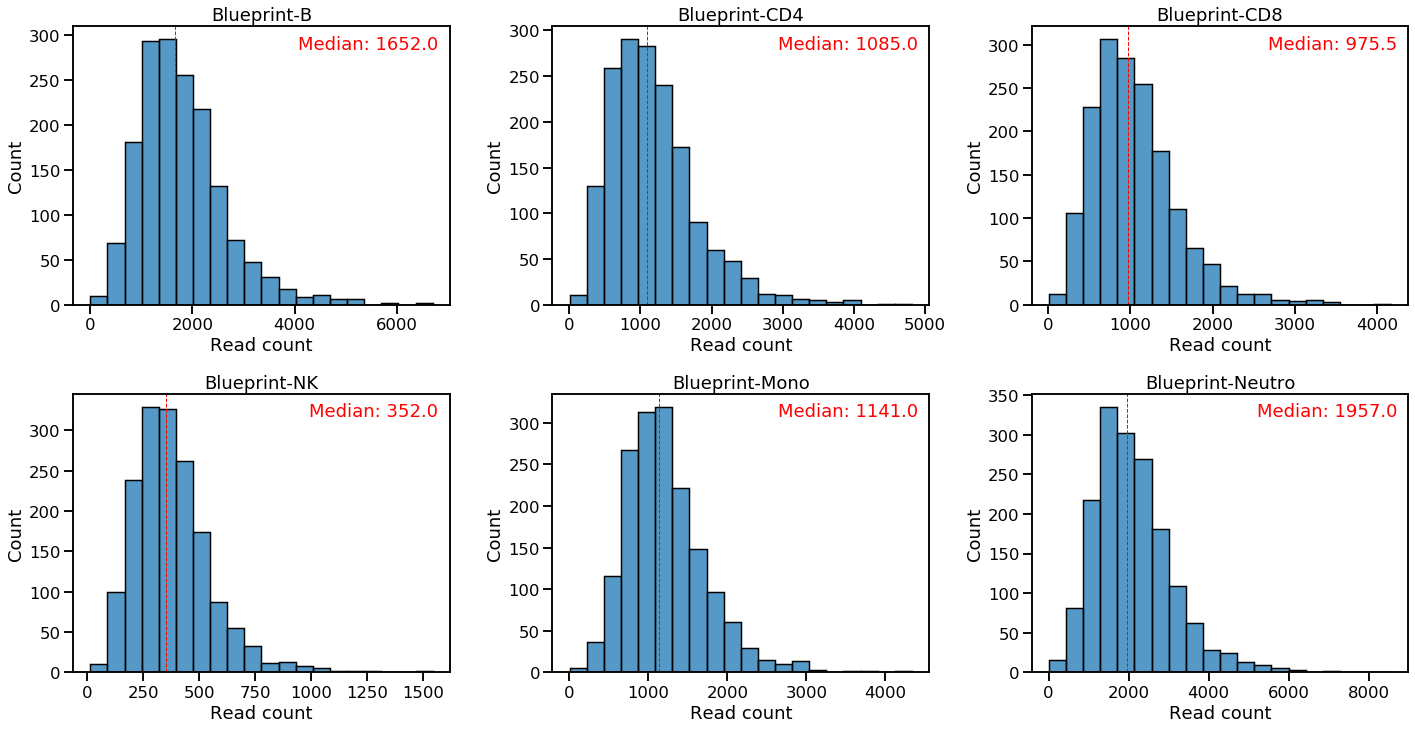

In [112]:
sns.set_context('talk')


celltype_subset = ['Blueprint-B', 'Blueprint-CD4', 'Blueprint-CD8', 'Blueprint-NK', 'Blueprint-Mono', 'Blueprint-Neutro']

matched_elements = [x for x in cellType if x in celltype_subset]
matched_indexes = [i for i, x in enumerate(cellType) if x in celltype_subset]

region_read_count_subset = [region_read_count[i] for i in matched_indexes]


# Create a large figure
fig = plt.figure(figsize=(20, 20))

# Loop over the dataframes
for i, (df, title) in enumerate(zip(region_read_count_subset, matched_elements), start=1):
    # Create a subplot for each dataframe
    ax = fig.add_subplot(4, 3, i)  

    # Plot the histogram of the 'count' column using seaborn
    sns.histplot(df['count'], bins=20, edgecolor='black', ax=ax)

    # Calculate the median
    median = df['count'].median()

    # Add a vertical line for the median
    ax.axvline(median, color='red', linestyle='dashed', linewidth=1)

    # Add text in the upper right corner
    ax.text(0.97, 0.97, f'Median: {median}', ha='right', va='top', transform=ax.transAxes, color='red') 

    # Set the title from the titles list
    ax.set_title(title)
    
    # Set x-axis label
    ax.set_xlabel('Read count')

# Add spacing between plots
plt.tight_layout()
# Display the plot
plt.show()